In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from matplotlib import transforms
import networkx as nx


import os
import sys
from importlib import reload

# local imports 
import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
reload(pcu)
reload(binning)
reload(filters)

<module 'filters' from '/home/cstansbu/git_repositories/scPoreC-analysis/notebooks/filters.py'>

In [3]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
assembly

,Chromosome,Total length,GenBank accession,RefSeq accession,chromEnd,chromStart
0,1,195154279,CM000994.3,NC_000067.7,195154279,0
1,2,181755017,CM000995.3,NC_000068.8,376909296,195154279
2,3,159745316,CM000996.3,NC_000069.7,536654612,376909296
3,4,156860686,CM000997.3,NC_000070.7,693515298,536654612
4,5,151758149,CM000998.3,NC_000071.7,845273447,693515298
5,6,149588044,CM000999.3,NC_000072.7,994861491,845273447
6,7,144995196,CM001000.3,NC_000073.7,1139856687,994861491
7,8,130127694,CM001001.3,NC_000074.7,1269984381,1139856687
8,9,124359700,CM001002.3,NC_000075.7,1394344081,1269984381
9,10,130530862,CM001003.3,NC_000076.7,1524874943,1394344081


In [4]:
def loadRawContactDirectory(dirpath, filetags, verbose=True):
    """A function to load a directory of contact tables"""
    results = {}
    for runId in filetags:
        df = pcu.loadContactTable(dirpath, runId)
        
        if verbose:
            print(f"{runId=} {df.shape=}")
        
        results[runId] = df
    return results
    
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
filetags = [f"run0{x}" for x in range(1, 8)]
# filetags = [f"run0{x}" for x in range(1, 2)]
rawCells = loadRawContactDirectory(dirpath, filetags)

print(f"{rawCells.keys()=}")

runId='run01' df.shape=(13386738, 38)
runId='run02' df.shape=(13046898, 38)
runId='run03' df.shape=(18685242, 38)
runId='run04' df.shape=(20486346, 38)
runId='run05' df.shape=(5043403, 38)
runId='run06' df.shape=(7310826, 38)
runId='run07' df.shape=(10525887, 38)
rawCells.keys()=dict_keys(['run01', 'run02', 'run03', 'run04', 'run05', 'run06', 'run07'])


In [5]:
rawCells['run01'].columns

Index(['read_name', 'read_length', 'read_idx', 'contact_is_direct',
       'contact_is_cis', 'contact_read_distance', 'contact_genome_distance',
       'contact_fragment_adjacent', 'contact_fragment_distance',
       'haplotype_pair_type', 'align1_align_idx', 'align1_chrom',
       'align1_start', 'align1_end', 'align1_strand', 'align1_mapping_quality',
       'align1_align_score', 'align1_align_base_qscore', 'align1_phase_set',
       'align1_phase_qual', 'align1_haplotype', 'align1_fragment_id',
       'align1_fragment_start', 'align1_fragment_end', 'align2_align_idx',
       'align2_chrom', 'align2_start', 'align2_end', 'align2_strand',
       'align2_mapping_quality', 'align2_align_score',
       'align2_align_base_qscore', 'align2_phase_set', 'align2_haplotype',
       'align2_fragment_id', 'align2_fragment_start', 'align2_fragment_end',
       'batch_id'],
      dtype='object')

In [6]:
reload(pcu)
reload(binning)
reload(filters)
    

def runAllFilters(cells, assembly, chromosome=None, verbose=True):
    """A function to filter all cells """
    
    results = {}
    
    for runId, df in cells.items():
        
        cf = cells[runId].copy()
    
        if chromosome is not None:
            cf = filters.chromosomalFilter(cf, assembly)
            cf = filters.removeYChrom(cf)
            cf = filters.filterChomosome(cf, chromosome)
            
        # merge the assmembly info
        cf = pcu.mergeAssembly(cf, assembly)
        
        if verbose:
            print("------------------------------")
            print(f"{runId=}")
    
        cf = filters.adjacentContactFilter(cf)
        cf = filters.selfLoopFilter(cf)
        cf = filters.mapQFilter(cf, lowerBound=30, upperBound=250)
        cf = filters.distalContactFilter(cf)
        cf = filters.closeContactFilter(cf)
        cf = filters.duplicateContactFilter(cf, retain=1)
        cf = filters.ligationProductFilter(cf, nProducts=4, verbose=False)

        cf = filters.establishContactSupport(cf, 
                                             radiusThreshold=1000000, 
                                             nContacts=3, 
                                             readSupport=False, 
                                             nReads=3,
                                             method=1)
        if verbose:
            print(f"{cf['contact_has_support'].value_counts()=}")
            
        cf = filters.supportedContactFilter(cf, readSupport=False)
        
        if verbose:
            res = pcu.getSummary(cf)
            pcu.printSummary(res)
            print()
            
        results[runId] = cf
        
    return results
    

filteredCells = runAllFilters(rawCells,
                              assembly, 
                              chromosome='NC_000068.8', 
#                               chromosome=None,
                              verbose=True)  

print(f"{filteredCells.keys()=}")

------------------------------
runId='run01'
cf['contact_has_support'].value_counts()=1    5224
0     126
Name: contact_has_support, dtype: int64
Total Reads 3593 (1.000)
Singletons 2565 (0.714)
Pairs 667 (0.186)
Multiway 361 (0.100)
-- -- --
Total Contacts 5224 (1.000)
cis Contacts 5224 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 5224 (1.000)
Direct Contacts 5224 (1.000)
Indirect Contacts 0 (0.000)

------------------------------
runId='run02'
cf['contact_has_support'].value_counts()=1    2662
0     162
Name: contact_has_support, dtype: int64
Total Reads 1936 (1.000)
Singletons 1451 (0.749)
Pairs 337 (0.174)
Multiway 148 (0.076)
-- -- --
Total Contacts 2662 (1.000)
cis Contacts 2662 (1.000)
trans Contacts 0 (0.000)
-- -- --
Total Contacts 2662 (1.000)
Direct Contacts 2662 (1.000)
Indirect Contacts 0 (0.000)

------------------------------
runId='run03'
cf['contact_has_support'].value_counts()=1    413
0    100
Name: contact_has_support, dtype: int64
Total Reads 283 (1.000

In [17]:
# make interaction networks
reload(pcu)
reload(binning)

chomosome = 2
chromLength = assembly['Total length'].tolist()[0]

chromLength

# resolution = 1000000 # 1mb scale
# chromBins = binning.getBins(chromLength, resolution)

# label1 = 'bin1'
# label2 = 'bin2'

# 181755017 / resolution

# matrices = {}

# for runId, data in filteredCells.items():
#     print(f"{runId=}")
    
#     chrom = binning.chromosomeBinData(data, 
#                                      chromBins, 
#                                      label1=label1, 
#                                      label2=label2)
    
#     A = pcu.getHic(chrom, chromBins, label1, label2)
#     print(f"{A.shape=}")
#     matrices[runId] = A
    
# print(f"{matrices.keys()}")

195154279

In [8]:
matrices['run01']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

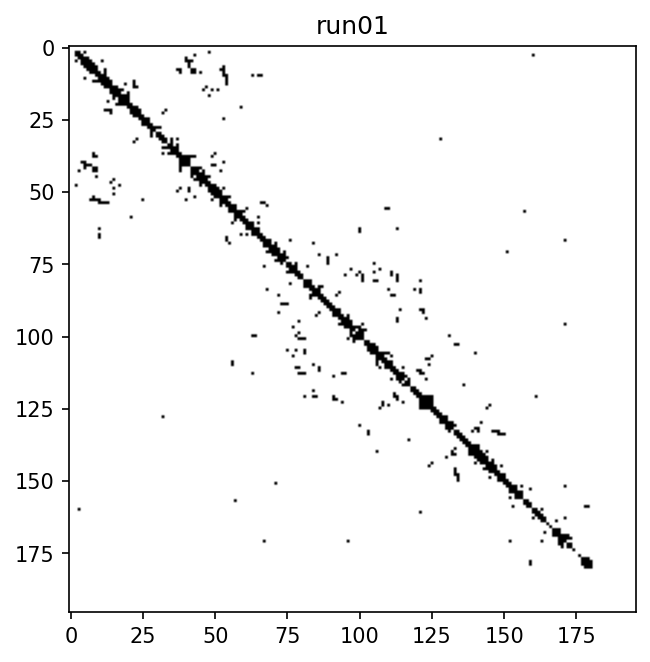

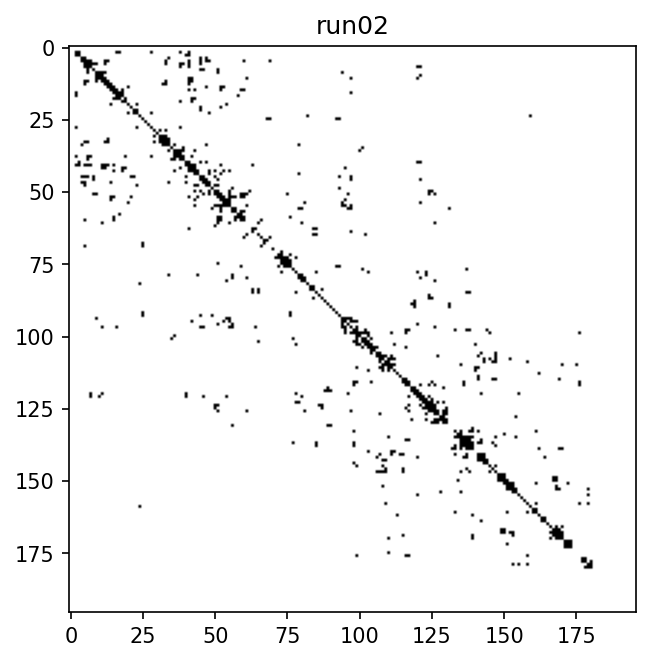

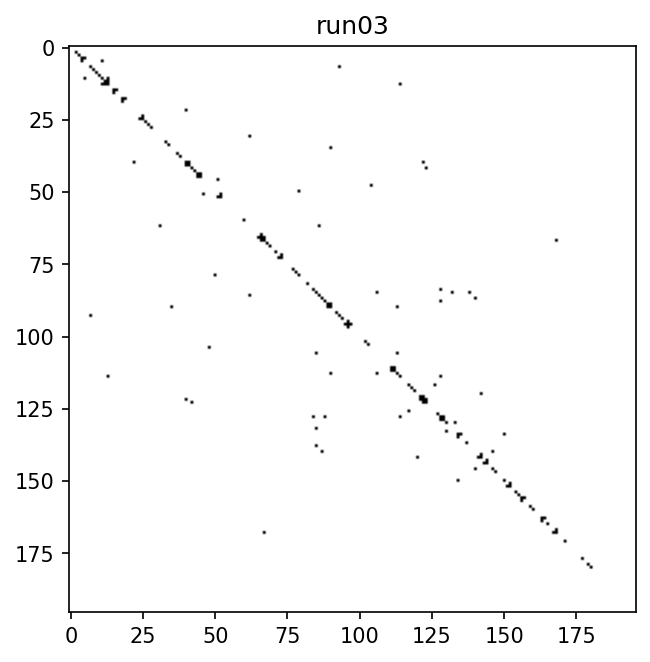

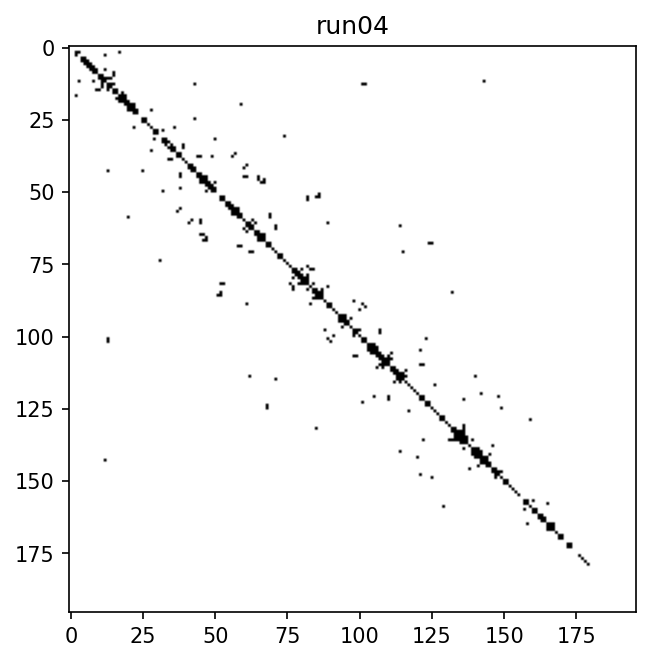

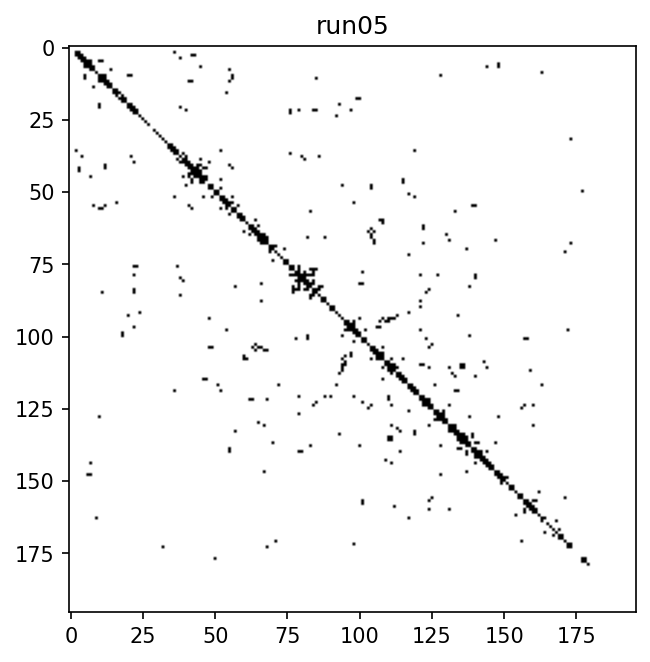

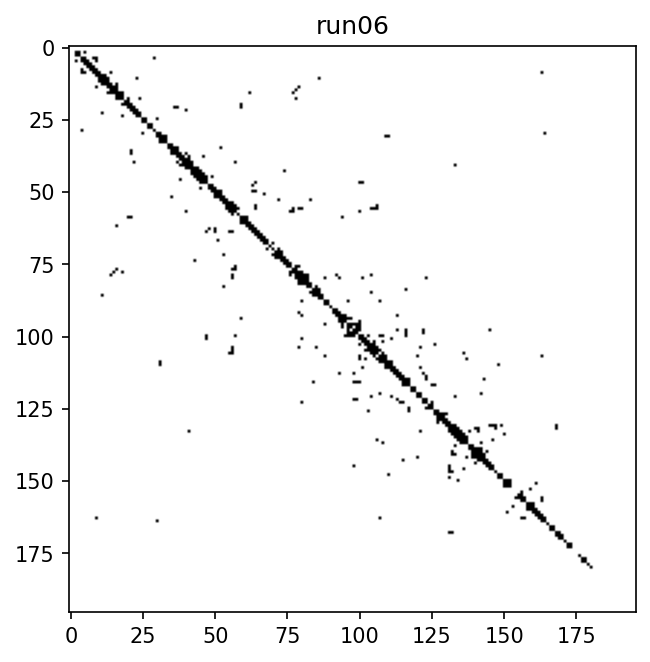

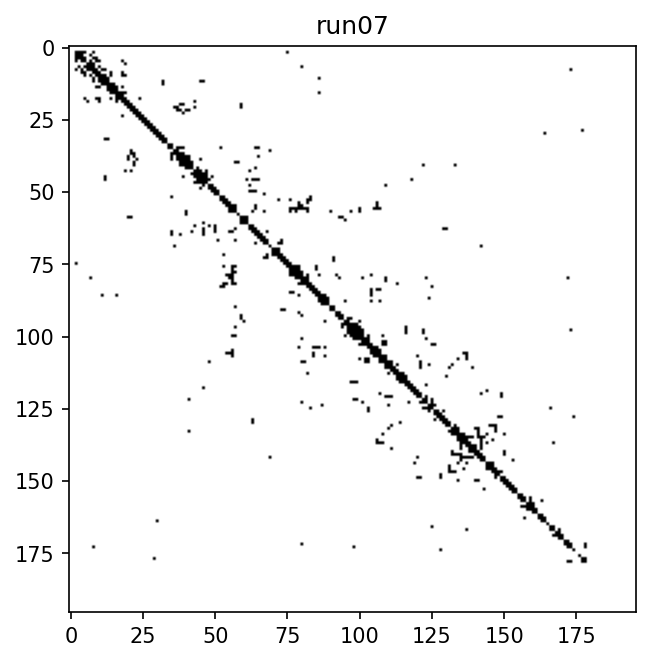

In [9]:
%matplotlib inline

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 5, 5

for runId, A in matrices.items():

    
    Abinary = np.where(A > 0, 1, 0)
    plt.imshow(Abinary, cmap='binary')
    plt.title(runId)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()